In [1]:
from konlpy.tag import Mecab
from collections import Counter

import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, GlobalMaxPooling1D
from tensorflow.keras.layers import Input, Conv1D, Dropout, Concatenate, Add
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
class ClassifierModel():
    def __init__(self, _type):
        super(ClassifierModel, self).__init__()
        
        self.tokenizer = Mecab()
        self.stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
        
        self.vocab_size = None
        self.word_vector_dim = 128
        
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.x_val = None
        self.y_val = None
        
        self.preprocess(['preprocessed_train'])
        
        if _type == 'cnn':
            self.model = self.CNN()
        elif _type == 'bi_lstm':
            self.model = self.BiLSTM()
        elif _type == 'bi_lstm_lstm':
            self.model = self.BiLSTM_LSTM()
        else:
            self.model = self.CNN_BiLSTM_LSTM()
            
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        self.history = None
        self.es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

    
    def data_load(self, datasets):
        
        _dir = '../../data'
        
        trains = []
        vals = []
        tests = []
        
        for ds in datasets:
            _df = pd.read_csv(f'{_dir}/{ds}.csv')
            
            _train = _df[:int(len(_df)*0.6)]
            _val = _df[int(len(_df)*0.6):int(len(_df)*0.8)]
            _test = _df[int(len(_df)*0.8):]
            
            vals.append(_val)
            tests.append(_test)
            trains.append(_train)
            
        train = pd.concat(trains)
        train.drop_duplicates(inplace=True)
        val = pd.concat(vals)
        val.drop_duplicates(inplace=True)
        test = pd.concat(tests)
        test.drop_duplicates(inplace=True)
        
        return train, val, test
    

    def preprocess_sentence(self, sentence):

        sentence = sentence.lower().strip()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
        sentence = sentence.strip()

        return sentence
    
    
    def tokenize(self, it):
        result = []
        for sentence in it:
            temp = self.tokenizer.morphs(sentence)
            temp = [word for word in temp if not word in self.stopwords] 
            result.append(temp)
        return result
    
    
    def pad_sequences(self, it, word_to_index):
        return tf.keras.preprocessing.sequence.pad_sequences(
            it, value=word_to_index["<PAD>"], padding='pre', maxlen=70)
    
    
    def preprocess(self, datasets):
        
        train, val, test = self.data_load(datasets)
        train['data'] = train['data'].apply(lambda it : self.preprocess_sentence(it))
        val['data'] = val['data'].apply(lambda it : self.preprocess_sentence(it))
        test['data'] = test['data'].apply(lambda it : self.preprocess_sentence(it))
        
        
        x_train = self.tokenize(train['data'])
        x_test = self.tokenize(test['data'])
        x_val = self.tokenize(val['data'])
        
        self.y_train = tf.keras.utils.to_categorical(train['label'], num_classes=4, dtype='float32')
        self.y_val = tf.keras.utils.to_categorical(val['label'], num_classes=4, dtype='float32')
        self.y_test = tf.keras.utils.to_categorical(test['label'], num_classes=4, dtype='float32')
        
        words = np.concatenate(x_train).tolist()
        counter = Counter(words)
        counter = counter.most_common(10000-4)
        vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
        word_to_index = { word:index for index, word in enumerate(vocab) }
        
        self.vocab_size = len(word_to_index)
        
        def wordlist_to_index_list(wordlist):
            return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
        x_train = list(map(wordlist_to_index_list, x_train))
        x_test = list(map(wordlist_to_index_list, x_test))
        x_val = list(map(wordlist_to_index_list, x_val))  
        
        self.x_train = self.pad_sequences(x_train, word_to_index)
        self.x_val = self.pad_sequences(x_val, word_to_index)
        self.x_test = self.pad_sequences(x_test, word_to_index)
    

    def CNN(self):
    
        inputs = Input(shape=(None, ))
        embedding = Embedding(self.vocab_size, self.word_vector_dim)(inputs)

        branches = []
        for filter_size in [3, 3]:
            branch = Conv1D(64, filter_size, activation='relu')(embedding)
            branch = GlobalMaxPooling1D()(branch)
            branches.append(branch)

        out = Concatenate()(branches)
        out = Dense(32, activation='relu')(out)
        out = Dropout(0.5)(out)

        out = Dense(4, activation='softmax')(out)
        model = Model(inputs=inputs, outputs=out)

        return model
    
    
    def BiLSTM(self):
    
        inputs = Input(shape=(None, ))
        embedding = Embedding(self.vocab_size, self.word_vector_dim)(inputs)

        out = Bidirectional(LSTM(64, dropout=0.1, return_sequences=True))(embedding)
        out = GlobalMaxPooling1D()(out)

        out = Dense(4, activation='softmax')(out)
        model = Model(inputs=inputs, outputs=out)

        return model
    
    
    def BiLSTM_LSTM(self):
    
        inputs = Input(shape=(None, ))
        embedding = Embedding(self.vocab_size, self.word_vector_dim)(inputs)

        bi_lstm = Bidirectional(LSTM(64, dropout=0.1, return_sequences=True))(embedding)
        residual_connection = Add()([embedding, bi_lstm])

        out = LSTM(64, return_sequences=True)(residual_connection)
        out = GlobalMaxPooling1D()(out)
        out = Dense(32, activation='relu')(out)
        out = Dropout(0.5)(out)

        out = Dense(4, activation='softmax')(out)
        model = Model(inputs=inputs, outputs=out)

        return model
    
    
    def CNN_BiLSTM_LSTM(self):
    
        inputs = Input(shape=(None, ))
        embedding = Embedding(self.vocab_size, self.word_vector_dim)(inputs)

        conv1 = Conv1D(64, 3, activation='relu')(embedding)
        conv_drop = Dropout(0.5)(embedding)

        bi_lstm = Bidirectional(LSTM(64, dropout=0.1, return_sequences=True))(conv_drop)
        residual_connection = Add()([embedding, bi_lstm])

        out = LSTM(64, return_sequences=True)(residual_connection)
        out = GlobalMaxPooling1D()(out)
        out = Dense(32, activation='relu')(out)
        out = Dropout(0.5)(out)

        out = Dense(4, activation='softmax')(out)
        model = Model(inputs=inputs, outputs=out)

        return model
    
    def train(self):
        self.history = self.model.fit(
            self.x_train, self.y_train, epochs=20, batch_size=64,
            validation_data=(self.x_val, self.y_val), callbacks=self.es, verbose=1)
        
    def show_report(self):
        y_pred = self.model.predict(self.x_test).argmax(axis=1)
        y_true = self.y_test.argmax(axis=1)
        
        print(f'accuracy : {accuracy_score(y_true, y_pred)}')
        print(f'macro f1 : {f1_score(y_true, y_pred, average="macro")}')
        print(f'weighted f1 : {f1_score(y_true, y_pred, average="weighted")}')
        
        conf_matrix = confusion_matrix(y_true, y_pred)
        names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘"]
        conf_matrix = pd.DataFrame(conf_matrix, index=names, columns=names)
        sns.heatmap(conf_matrix, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.show()

Epoch 1/20
38/38 [==============================] - 4s 19ms/step - loss: 1.3488 - accuracy: 0.3502 - val_loss: 1.2847 - val_accuracy: 0.5241
Epoch 2/20
38/38 [==============================] - 0s 6ms/step - loss: 1.1467 - accuracy: 0.5890 - val_loss: 1.0202 - val_accuracy: 0.6886
Epoch 3/20
38/38 [==============================] - 0s 6ms/step - loss: 0.8774 - accuracy: 0.7063 - val_loss: 0.7766 - val_accuracy: 0.7532
Epoch 4/20
38/38 [==============================] - 0s 5ms/step - loss: 0.6308 - accuracy: 0.8059 - val_loss: 0.6402 - val_accuracy: 0.7823
Epoch 5/20
38/38 [==============================] - 0s 6ms/step - loss: 0.4505 - accuracy: 0.8717 - val_loss: 0.5712 - val_accuracy: 0.8127
Epoch 6/20
38/38 [==============================] - 0s 5ms/step - loss: 0.3382 - accuracy: 0.9110 - val_loss: 0.5335 - val_accuracy: 0.8266
Epoch 7/20
38/38 [==============================] - 0s 5ms/step - loss: 0.2369 - accuracy: 0.9460 - val_loss: 0.5233 - val_accuracy: 0.8266
Epoch 8/20
38/38 [=

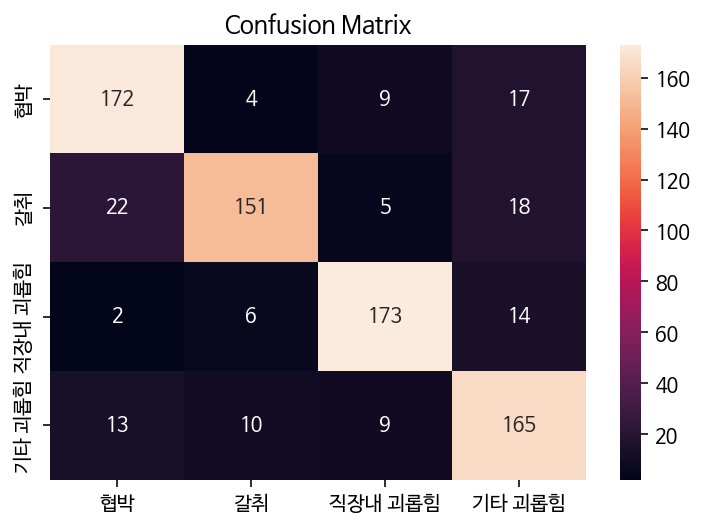

In [3]:
cnn = ClassifierModel('cnn')
cnn.train()
cnn.show_report()

Epoch 1/20
38/38 [==============================] - 4s 34ms/step - loss: 1.3471 - accuracy: 0.3523 - val_loss: 1.2168 - val_accuracy: 0.6430
Epoch 2/20
38/38 [==============================] - 0s 10ms/step - loss: 0.8600 - accuracy: 0.6776 - val_loss: 0.7772 - val_accuracy: 0.7190
Epoch 3/20
38/38 [==============================] - 0s 10ms/step - loss: 0.4290 - accuracy: 0.8650 - val_loss: 0.6994 - val_accuracy: 0.7570
Epoch 4/20
38/38 [==============================] - 0s 10ms/step - loss: 0.2341 - accuracy: 0.9321 - val_loss: 0.6584 - val_accuracy: 0.7975
Epoch 5/20
38/38 [==============================] - 0s 10ms/step - loss: 0.1351 - accuracy: 0.9654 - val_loss: 0.7305 - val_accuracy: 0.7835
Epoch 6/20
38/38 [==============================] - 0s 10ms/step - loss: 0.1155 - accuracy: 0.9696 - val_loss: 1.0299 - val_accuracy: 0.6848
Epoch 7/20
38/38 [==============================] - 0s 10ms/step - loss: 0.1489 - accuracy: 0.9515 - val_loss: 0.7085 - val_accuracy: 0.7987
Epoch 8/20
38

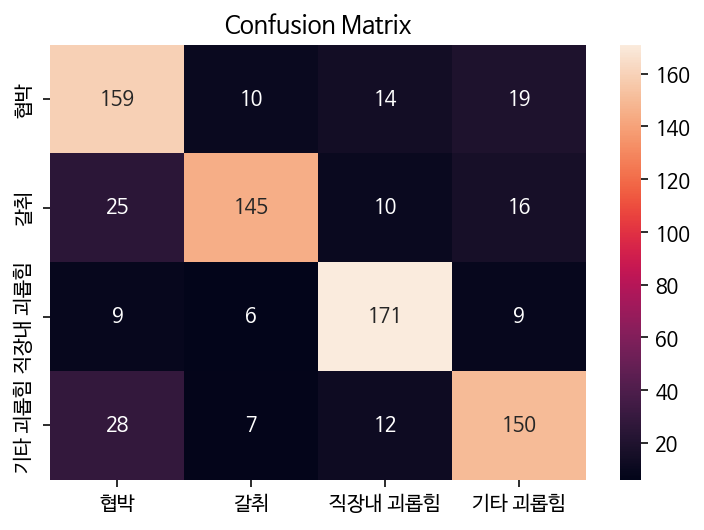

In [4]:
bi_lstm = ClassifierModel('bi_lstm')
bi_lstm.train()
bi_lstm.show_report()

Epoch 1/20
38/38 [==============================] - 5s 40ms/step - loss: 1.3590 - accuracy: 0.3511 - val_loss: 1.2025 - val_accuracy: 0.5570
Epoch 2/20
38/38 [==============================] - 1s 14ms/step - loss: 1.0069 - accuracy: 0.5924 - val_loss: 0.9791 - val_accuracy: 0.6215
Epoch 3/20
38/38 [==============================] - 1s 14ms/step - loss: 0.7155 - accuracy: 0.7316 - val_loss: 0.7523 - val_accuracy: 0.6899
Epoch 4/20
38/38 [==============================] - 1s 13ms/step - loss: 0.4665 - accuracy: 0.8422 - val_loss: 0.7129 - val_accuracy: 0.7418
Epoch 5/20
38/38 [==============================] - 1s 13ms/step - loss: 0.3259 - accuracy: 0.9063 - val_loss: 0.9789 - val_accuracy: 0.6797
Epoch 6/20
38/38 [==============================] - 1s 13ms/step - loss: 0.3644 - accuracy: 0.8869 - val_loss: 0.7163 - val_accuracy: 0.7759
Epoch 7/20
38/38 [==============================] - 1s 13ms/step - loss: 0.1651 - accuracy: 0.9599 - val_loss: 0.9027 - val_accuracy: 0.7772
Epoch 8/20
38

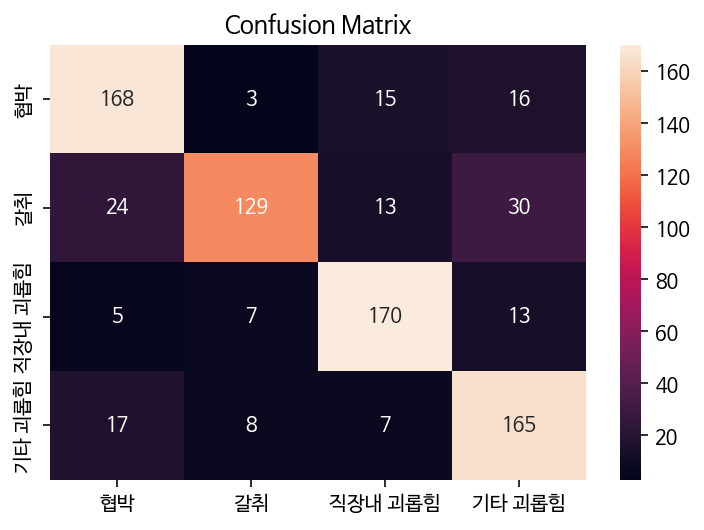

In [5]:
bilstm_lstm = ClassifierModel('bi_lstm_lstm')
bilstm_lstm.train()
bilstm_lstm.show_report()

Epoch 1/20
38/38 [==============================] - 5s 39ms/step - loss: 1.3603 - accuracy: 0.3236 - val_loss: 1.1754 - val_accuracy: 0.4861
Epoch 2/20
38/38 [==============================] - 1s 13ms/step - loss: 1.0696 - accuracy: 0.5371 - val_loss: 0.8853 - val_accuracy: 0.6354
Epoch 3/20
38/38 [==============================] - 1s 13ms/step - loss: 0.7024 - accuracy: 0.7544 - val_loss: 0.6755 - val_accuracy: 0.7684
Epoch 4/20
38/38 [==============================] - 1s 14ms/step - loss: 0.4459 - accuracy: 0.8730 - val_loss: 0.6208 - val_accuracy: 0.7911
Epoch 5/20
38/38 [==============================] - 1s 13ms/step - loss: 0.2788 - accuracy: 0.9241 - val_loss: 0.7198 - val_accuracy: 0.7570
Epoch 6/20
38/38 [==============================] - 1s 13ms/step - loss: 0.1830 - accuracy: 0.9485 - val_loss: 0.7061 - val_accuracy: 0.8051
Epoch 7/20
38/38 [==============================] - 1s 13ms/step - loss: 0.1474 - accuracy: 0.9641 - val_loss: 0.8915 - val_accuracy: 0.7823
Epoch 8/20
38

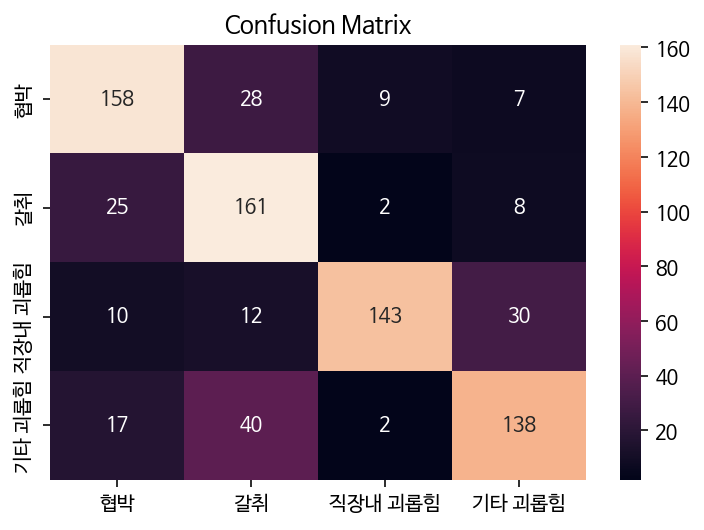

In [6]:
cnn_bilstm_lstm = ClassifierModel('cnn_bilstm_lstm')
cnn_bilstm_lstm.train()
cnn_bilstm_lstm.show_report()

|모델|Accuracy|weighted f1|macro f1|
|:---:|---|---|:---:|
|CNN|0.8367|0.8368|0.8369|
|BiLSTM|0.7911|0.7916|0.7912|
|BiLSTM + LSTM|0.8|0.7984|0.7984|
|CNN + BiLSTM + LSTM|0.7595|0.7611|0.7612|